In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
import pandas as pd

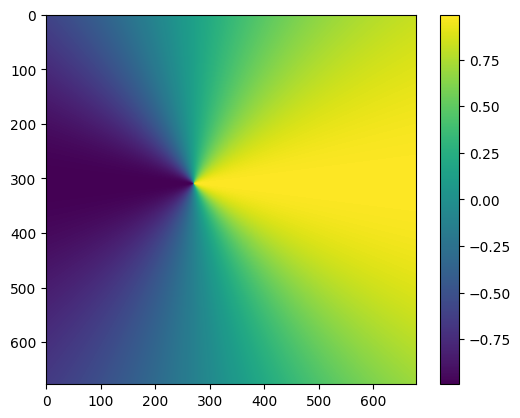

In [2]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.2, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


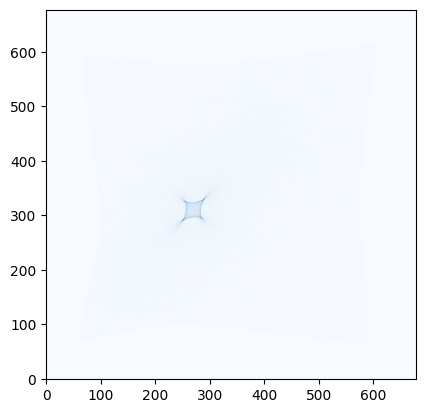

In [3]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()

In [4]:
beta = (260.4,305.9) #in pixel
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, 0.5 , 1.5, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale)


Image 1 position: [1.69477609 3.57053035]
Predicted Image 1 position: [1.69476513 3.57051388]
Difference: 1.9776738504773148e-05
Image 2 position: [2.13510797 2.25733017]
Predicted Image 2 position: [2.13509987 2.25731932]
Difference: 1.3541361938026426e-05
Image 3 position: [2.99786319 2.10496328]
Predicted Image 3 position: [2.99786546 2.10495655]
Difference: 7.100359626605167e-06
Image 4 position: [3.33547624 3.62228173]
Predicted Image 4 position: [3.33547916 3.62230713]
Difference: 2.556296070780781e-05


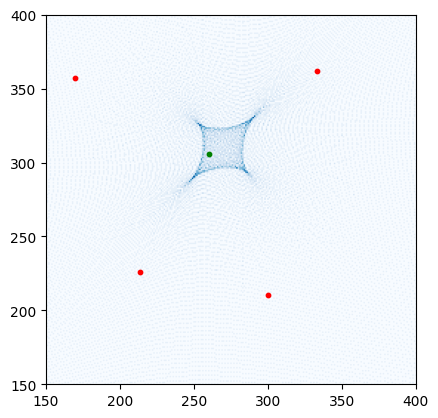

In [5]:


# lenstronomy
solver = LensEquationSolver(lensModel)
thetax, thetay = solver.image_position_analytical(beta[0], beta[1], kwargs_lens)

theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i], thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical * pixscale, key=lambda x: x[0])  # sort by x coordinate

# my class
theta_numerical = np.array(cluster.get_image_positions())
sorted_theta_numerical = sorted(theta_numerical, key=lambda x: x[0])  # sort by x coordinate
plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
plt.scatter(thetax, thetay, color='red', s=10)
plt.scatter(beta[0], beta[1], color='green', s=10)
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()
plt.xlim(150,400)
plt.ylim(150,400)

for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {sorted_theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (sorted_theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   


In [6]:
print("Numerical:")
mag_table = cluster.get_magnifications() #output a dataframe
print(mag_table)

# Analytical magnifications
data_analytical = []
print("Analytical:")
for i in range(len(thetax)):
    x, y = thetax[i], thetay[i]
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    data_analytical.append({'x': x * pixscale, 'y': y * pixscale, 'magnification': mag})
    

table_analytical = pd.DataFrame(data_analytical)
pd.options.display.float_format = '{:.12f}'.format
table_analytical = table_analytical.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table_analytical)

Numerical:
               x              y   magnification
0 1.694776085394 3.570530348315  4.128826446284
1 2.135107969076 2.257330173881 -5.604413013584
2 2.997863194743 2.104963283628  6.341394379624
3 3.335476239791 3.622281730333 -2.092009299373
Analytical:
               x              y   magnification
0 1.694765133447 3.570513881111  4.177310353975
1 2.135099868911 2.257319322327 -5.562630469417
2 2.997865457626 2.104956553479  6.268601256645
3 3.335479163905 3.622307125510 -2.082480883850


In [7]:
# time delay
print("Numerical:")
dt = cluster.get_time_delays()
print(dt)


'''data_dt = []
for i in range(len(theta_numerical)):
    x, y = theta_numerical[i]
    delay = dt[i]       # in days
    data_dt.append({'x': x, 'y': y, 'delta_t': delay})

table = pd.DataFrame(data_dt)
pd.options.display.float_format = '{:.12f}'.format
table = table.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table)'''

# restore the lens model in arcsec
kwargs_sie = {'theta_E': 100 * pixscale, 'e1':0, 'e2':0.2, 'center_x': 270 * pixscale, 'center_y': 310 * pixscale}
kwargs_lens = [kwargs_sie]
z_s = 1.5
z_l = 0.5
lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
t_analytical = lensModel.arrival_time(thetax * pixscale, thetay * pixscale, kwargs_lens, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - t_analytical[0]

data_dt_analytical = []
for i in range(len(thetax)):
    x, y = theta_analytical[i] * pixscale
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)

Numerical:
         theta_x        theta_y       d_fermat   delta_t(days)
0 1.694776085535 3.570530348527 0.000000000000  0.000000000000
1 2.997863195183 2.104963283764 0.076518488048  7.133995013451
2 2.135107969143 2.257330173830 0.101318314214  9.446139969686
3 3.335476239807 3.622281730332 0.277609094017 25.882135715383
Analytical:
         theta_x        theta_y         delta_t
0 1.694765133447 3.570513881111  0.000000000000
1 2.997865457626 2.104956553479  7.378072510760
2 2.135099868911 2.257319322327  9.769810698523
3 3.335479163905 3.622307125510 26.767363367837


In [ ]:
#test multiple source plane lensing code